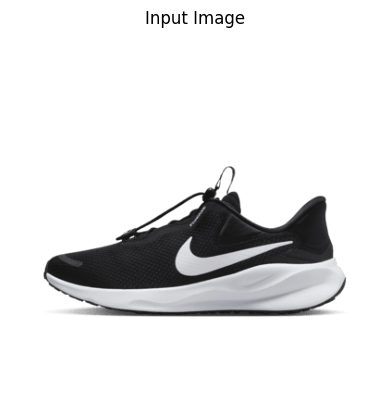

Processing Image: nike.jpg

Detected Labels:
  - Shoe (Confidence: 0.95)
  - Sportswear (Confidence: 0.93)
  - Nike Free (Confidence: 0.90)
  - Running Shoe (Confidence: 0.89)
  - Cross Training Shoe (Confidence: 0.84)
  - Walking Shoe (Confidence: 0.84)
  - Outdoor Shoe (Confidence: 0.75)
  - Tennis Shoe (Confidence: 0.72)
  - Basketball Shoe (Confidence: 0.67)
  - Skate shoe (Confidence: 0.58)

Detected Objects:
  - Shoe (Confidence: 0.80)
  - Shoe (Confidence: 0.72)

Detected Logos:
  - Nike (Confidence: 0.97)
  - Nike (Confidence: 0.70)

Detected Text:
  - No text detected.

Detected Colors:
  - RGB: (25, 25, 26) → Color: Black (Confidence: 0.48)
  - RGB: (195, 196, 200) → Color: Silver (Confidence: 0.20)
  - RGB: (46, 46, 47) → Color: Black (Confidence: 0.13)

Processing Keyword Sentence...

Generated Keyword Sentence: Black and Silver Nike Shoe


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\geeth\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
import os
from google.cloud import vision
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set Google Cloud credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "sunny-furnace-450323-j7-fb55f0c1398a.json"

# Define basic color names with approximate RGB values
COLOR_NAMES = {
    "Black": (0, 0, 0),
    "White": (255, 255, 255),
    "Red": (255, 0, 0),
    "Lime": (0, 255, 0),
    "Blue": (0, 0, 255),
    "Yellow": (255, 255, 0),
    "Cyan": (0, 255, 255),
    "Magenta": (255, 0, 255),
    "Silver": (192, 192, 192),
    "Gray": (128, 128, 128),
    "Maroon": (128, 0, 0),
    "Olive": (128, 128, 0),
    "Green": (0, 128, 0),
    "Purple": (128, 0, 128),
    "Teal": (0, 128, 128),
    "Navy": (0, 0, 128),
    "Orange": (255, 165, 0),
    "Pink": (255, 192, 203),
    "Brown": (165, 42, 42),
    "Gold": (255, 215, 0)
}

def closest_color(requested_color):
    """Find the closest human-readable color name for an RGB value."""
    min_distance = float("inf")
    closest_name = None
    for name, rgb in COLOR_NAMES.items():
        distance = sqrt((rgb[0] - requested_color[0]) ** 2 + 
                        (rgb[1] - requested_color[1]) ** 2 + 
                        (rgb[2] - requested_color[2]) ** 2)
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    return closest_name

def detect_image_features(path):
    """Detects labels, objects, logos, text, and dominant colors and generates a keyword-based description."""
    client = vision.ImageAnnotatorClient()

    # Load Image
    with open(path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    print(f"Processing Image: {path}")

    # Label Detection
    label_response = client.label_detection(image=image)
    labels = label_response.label_annotations
    label_list = [(label.description, label.score) for label in labels]
    print("\nDetected Labels:")
    for label in label_list:
        print(f"  - {label[0]} (Confidence: {label[1]:.2f})")

    # Object Detection
    object_response = client.object_localization(image=image)
    objects = object_response.localized_object_annotations
    object_list = [(obj.name, obj.score) for obj in objects]
    print("\nDetected Objects:")
    for obj in object_list:
        print(f"  - {obj[0]} (Confidence: {obj[1]:.2f})")

    # Logo Detection (Brand Extraction)
    logo_response = client.logo_detection(image=image)
    logos = logo_response.logo_annotations
    logo_list = [(logo.description, logo.score) for logo in logos]
    print("\nDetected Logos:")
    for logo in logo_list:
        print(f"  - {logo[0]} (Confidence: {logo[1]:.2f})")

    # OCR - Text Detection (Backup for Brand Extraction)
    text_response = client.text_detection(image=image)
    texts = text_response.text_annotations
    text_detected = texts[0].description if texts else None
    print("\nDetected Text:")
    if text_detected:
        print(f"  - Extracted Text: {text_detected}")
    else:
        print("  - No text detected.")

    # Color Detection
    image_props_response = client.image_properties(image=image)
    props = image_props_response.image_properties_annotation
    color_list = []
    
    print("\nDetected Colors:")
    for color in props.dominant_colors.colors[:3]:  # Get top 3 colors
        rgb_value = (int(color.color.red), int(color.color.green), int(color.color.blue))
        color_name = closest_color(rgb_value)  # Convert RGB to color name
        
        # Append color name and confidence score
        color_list.append((color_name, color.score))
        print(f"  - RGB: {rgb_value} → Color: {color_name} (Confidence: {color.score:.2f})")

    # Remove duplicate colors (if top 2 colors are the same, keep only one)
    dominant_colors = sorted(color_list, key=lambda x: x[1], reverse=True)[:2]  # Get top 2
    if len(dominant_colors) > 1 and dominant_colors[0][0] == dominant_colors[1][0]:
        dominant_colors = [dominant_colors[0]]  # Keep only one instance
    
    # Extract the most confident data
    detected_objects = sorted(object_list, key=lambda x: x[1], reverse=True)[:1]
    top_labels = sorted(label_list, key=lambda x: x[1], reverse=True)[:2]
    detected_brand = sorted(logo_list, key=lambda x: x[1], reverse=True)[:1]

    print("\nProcessing Keyword Sentence...")

    import nltk
    from nltk.corpus import words
    
    # Download word list if not already downloaded
    nltk.download('words')
    
    # Get a set of common English words
    common_words = set(words.words())

    # Additional custom stopwords (optional)
    custom_stopwords = {"HDMI", "DELETE", "ENTER", "END", "SUPER", "SPORT", "BICYCLE"}

    # Determine the brand name
    brand_keyword = detected_brand[0][0] if detected_brand else None

    # If no logo detected, use OCR-extracted text as backup
    if not brand_keyword and text_detected:
        words = text_detected.split()
        for word in words:
            if (word.istitle() or word.isupper()) and word not in common_words and word not in custom_stopwords:
                brand_keyword = word
                print(f"\nBrand extracted from OCR: {brand_keyword}")
                break
            
    '''# If no logo detected, use OCR-extracted text as backup
    if not brand_keyword and text_detected:
        words = text_detected.split()
        for word in words:
            if word.istitle():  # Checking for possible brand name (Proper noun heuristic)
                brand_keyword = word
                print(f"\nBrand extracted from OCR: {brand_keyword}")
                break'''

    # Constructing the keyword sentence
    color_keywords = [color[0] for color in dominant_colors]
    object_keywords = [obj[0] for obj in detected_objects]
    label_keywords = [label[0] for label in top_labels]

    description_parts = []
    if color_keywords:
        description_parts.append(" and ".join(color_keywords))
    if brand_keyword:
        description_parts.append(brand_keyword)
    if object_keywords:
        description_parts.append(object_keywords[0])
    elif label_keywords:
        description_parts.append(label_keywords[0])

    keyword_sentence = " ".join(description_parts)
    
    print(f"\nGenerated Keyword Sentence: {keyword_sentence}")

    return keyword_sentence

# Display the input image
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title("Input Image")
    plt.show()

# Call the function to display the image
show_image('nike.jpg')

# Run detection

keyword_phrase = detect_image_features('nike.jpg')